In [11]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [12]:
# Veriyi indirme ve işleme adımları
ticker_symbol = "AAPL"
start_date = "2010-01-01"
end_date = "2022-01-01"

data = yf.download(ticker_symbol, start=start_date, end=end_date)
ohlc_data = data[['Open', 'High', 'Low', 'Close']].values

scaler = MinMaxScaler()
ohlc_data_scaled = scaler.fit_transform(ohlc_data)

[*********************100%%**********************]  1 of 1 completed


In [13]:
# Veriyi eğitim ve test setlerine ayırma
train_size = int(len(ohlc_data_scaled) * 0.80)
train_data, test_data = ohlc_data_scaled[:train_size], ohlc_data_scaled[train_size:]

# Zaman serisi verilerini oluşturma fonksiyonu
def create_time_series_data(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, :])
    return np.array(X), np.array(Y)

look_back = 60  # Zaman serisi uzunluğu
X_train, y_train = create_time_series_data(train_data, look_back)
X_test, y_test = create_time_series_data(test_data, look_back)

# Verileri LSTM modeline uygun hale getirme
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 4))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 4))


In [14]:
# Gelişmiş LSTM modeli oluşturma
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 4)))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=4))

model.compile(loss='mean_squared_error', optimizer='adam')

# Modeli eğitme
model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
74/74 [==============================] - 9s 54ms/step - loss: 0.0010
Epoch 2/10
74/74 [==============================] - 4s 52ms/step - loss: 2.2485e-04
Epoch 3/10
74/74 [==============================] - 3s 45ms/step - loss: 1.9673e-04
Epoch 4/10
74/74 [==============================] - 3s 46ms/step - loss: 1.6383e-04
Epoch 5/10
74/74 [==============================] - 3s 45ms/step - loss: 1.5843e-04
Epoch 6/10
74/74 [==============================] - 3s 45ms/step - loss: 1.4350e-04
Epoch 7/10
74/74 [==============================] - 4s 48ms/step - loss: 1.2567e-04
Epoch 8/10
74/74 [==============================] - 4s 52ms/step - loss: 1.3685e-04
Epoch 9/10
74/74 [==============================] - 3s 47ms/step - loss: 1.0933e-04
Epoch 10/10
74/74 [==============================] - 4s 48ms/step - loss: 9.7750e-05


In [15]:
# Tahminleri yapma
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Tahminleri ters çevirme (normalize edilmemiş haline geri getirme)
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test)

# Eğitim ve test hatası hesaplama
train_score = np.sqrt(mean_squared_error(y_train, train_predict))
test_score = np.sqrt(mean_squared_error(y_test, test_predict))
print(f"Eğitim hatası (RMSE): {train_score:.2f}")
print(f"Test hatası (RMSE): {test_score:.2f}")

18/18 [==============================] - 0s 15ms/step
Eğitim hatası (RMSE): 1.14
Test hatası (RMSE): 12.17


ValueError: x and y must have same first dimension, but have shapes (543,) and (545,)

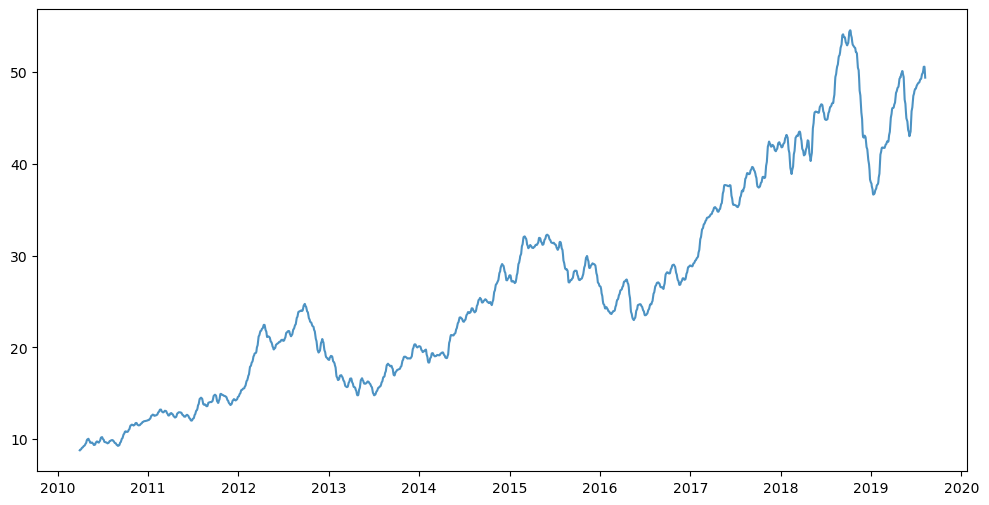

In [16]:
# Tahminleri görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(data.index[look_back:len(train_predict) + look_back], train_predict[:, 3], label="Eğitim Tahmin (Close)", alpha=0.8)
plt.plot(data.index[len(train_predict) + (look_back * 2) + 1:len(ohlc_data_scaled) - 1], test_predict[:, 3], label="Test Tahmin (Close)", alpha=0.8)
plt.plot(data.index[look_back:len(train_predict) + look_back], ohlc_data[look_back:len(train_predict) + look_back, 3], label="Gerçek Fiyat (Close)", color='red')
plt.legend()
plt.xlabel('Tarih')
plt.ylabel('Fiyatlar')
plt.title('Hisse Senedi Fiyat Tahmini')
plt.show()